In [1]:
import pandas as pd

In [2]:
airline_city_pairs = pd.read_excel("../data/world_flights/1000 Largest City Pairs by Number of Passengers.xlsx")

In [3]:
airline_city_pairs = airline_city_pairs[1:]  # Drop "Grand Total" header.

In [4]:
# airline_city_pairs

In [5]:
airline_city_pairs['Origin'] = airline_city_pairs['ORIGIN_CITY_NAME - DEST_CITY_NAME'].map(
    lambda pair: pair[:pair.index("-") - 1]
)

In [6]:
airline_city_pairs['Destination'] = airline_city_pairs['ORIGIN_CITY_NAME - DEST_CITY_NAME'].map(
    lambda pair: pair[pair.index("-") + 2:-6]
)

In [7]:
airline_city_pairs = airline_city_pairs.drop('ORIGIN_CITY_NAME - DEST_CITY_NAME', axis='columns')

In [8]:
# airline_city_pairs

In [9]:
cities = pd.concat([airline_city_pairs['Origin'], airline_city_pairs['Destination']]).drop_duplicates()

In [10]:
import geocoder
g = geocoder.google('Mountain View, CA')

In [11]:
latlngs = cities.map(lambda city: geocoder.google(city).latlng)

In [12]:
len(cities)

119

In [13]:
len(latlngs)

119

In [15]:
import numpy as np

In [16]:
lats =  [tup[0] if len(tup) > 0 else np.nan for tup in latlngs.values]
longs = [tup[1] if len(tup) > 0 else np.nan for tup in latlngs.values]

In [17]:
cities = pd.DataFrame(cities).rename(columns={0: 'city'}).assign(latitude=lats, longitude=longs)

In [18]:
cities[cities['latitude'].isnull()]

,city,latitude,longitude
391,"Guam, TT",NaN,NaN


In [19]:
guam = geocoder.google('Guam')

In [20]:
greens = geocoder.google('Greensboro, NC')

In [21]:
cities.loc[391]['latitude'] = guam.latlng[0]
cities.loc[391]['longitude'] = guam.latlng[1]

/Users/Honors/anaconda/envs/geoplot/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Honors/anaconda/envs/geoplot/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [35]:
cities.loc[391] = pd.Series({'city': 'Guam, TT', 'latitude': guam.latlng[0], 'longitude': guam.latlng[1]})
cities.loc[929] = pd.Series({'city': 'Greensboro/High Point, NC', 'latitude': greens.latlng[0], 'longitude': greens.latlng[1]})

In [23]:
cities.query('city == "New York, NY"')['latitude'].iloc[0]

40.7127837

In [37]:
airline_city_pairs['Origin Latitude'] = airline_city_pairs['Origin'].map(
    lambda city: cities.query('city == @city')['latitude'].iloc[0]
)
airline_city_pairs['Origin Longitude'] = airline_city_pairs['Origin'].map(
    lambda city: cities.query('city == @city')['longitude'].iloc[0]
)
airline_city_pairs['Destination Latitude'] = airline_city_pairs['Destination'].map(
    lambda city: cities.query('city == @city')['latitude'].iloc[0]
)
airline_city_pairs['Destination Longitude'] = airline_city_pairs['Destination'].map(
    lambda city: cities.query('city == @city')['longitude'].iloc[0]
)

In [38]:
from shapely.geometry import Point

airline_city_pairs['Starting Point'] = airline_city_pairs.apply(
    lambda srs: Point(srs['Origin Longitude'], srs['Origin Latitude']),
    axis='columns'
)
airline_city_pairs['Ending Point'] = airline_city_pairs.apply(
    lambda srs: Point(srs['Destination Longitude'], srs['Destination Latitude']),
    axis='columns'
)

In [39]:
cols = [c for c in airline_city_pairs.columns if ('Latitude' not in c and 'Longitude' not in c)]
airline_city_pairs = airline_city_pairs[cols]

In [47]:
airline_city_pairs['Starting Point'] = gpd.GeoSeries(airline_city_pairs['Starting Point'])
airline_city_pairs['Ending Point'] = gpd.GeoSeries(airline_city_pairs['Ending Point'])

In [48]:
import geopandas as gpd
gpd.GeoDataFrame(airline_city_pairs, geometry=[Point(0, 0) for _ in range(len(airline_city_pairs))])\
    .to_file("../data/world_flights/flights.geojson")

ValueError: Invalid field type <class 'shapely.geometry.point.Point'>

TIL: `GeoPandas` can't write `shapely` GeoSeries fields...it's possible to work around this by using a MultiPoint and more piping.

In [40]:
airline_city_pairs

,PASSENGERS,Passenger Miles,Origin,Destination,Starting Point,Ending Point
1,2087353,1529761202,"New York, NY","Chicago, IL",POINT (-74.0059413 40.7127837),POINT (-87.6297982 41.8781136)
2,2076870,1522172342,"Chicago, IL","New York, NY",POINT (-87.6297982 41.8781136),POINT (-74.0059413 40.7127837)
3,1863155,627883235,"Los Angeles, CA","San Francisco, CA",POINT (-118.2436849 34.0522342),POINT (-122.4194155 37.7749295)
4,1845634,621978658,"San Francisco, CA","Los Angeles, CA",POINT (-122.4194155 37.7749295),POINT (-118.2436849 34.0522342)
5,1698805,4204515375,"Los Angeles, CA","New York, NY",POINT (-118.2436849 34.0522342),POINT (-74.0059413 40.7127837)
6,1678680,4154701728,"New York, NY","Los Angeles, CA",POINT (-74.0059413 40.7127837),POINT (-118.2436849 34.0522342)
7,1600612,2793176782,"Los Angeles, CA","Chicago, IL",POINT (-118.2436849 34.0522342),POINT (-87.6297982 41.8781136)
8,1573814,5432802126,"London, United Kingdom","New York, NY",POINT (-0.1277583 51.5073509),POINT (-74.0059413 40.7127837)
9,1562727,5394605727,"New York, NY","London, United Kingdom",POINT (-74.0059413 40.7127837),POINT (-0.1277583 51.5073509)
10,1558362,2719518378,"Chicago, IL","Los Angeles, CA",POINT (-87.6297982 41.8781136),POINT (-118.2436849 34.0522342)


In [125]:
import sys; sys.path.insert(0, '../')
import geoplot as gplt
import geoplot.crs as ccrs
%matplotlib inline

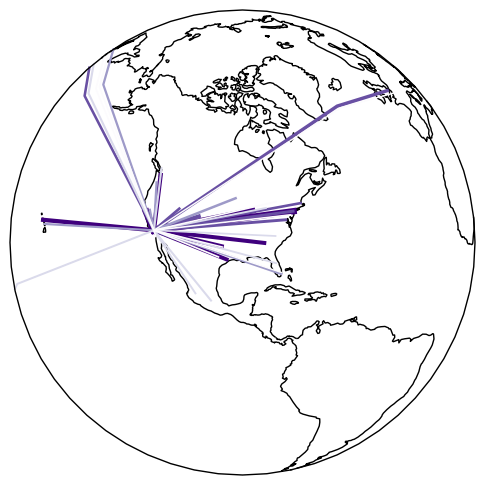

In [160]:
ax = gplt.sankey(airline_city_pairs.query('Origin == "Los Angeles, CA"'), start='Starting Point', end='Ending Point',
                 projection=ccrs.Orthographic(), scale='PASSENGERS', hue='PASSENGERS', cmap='Purples')
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()

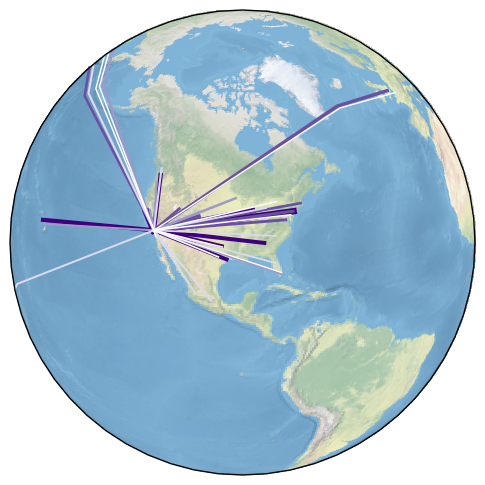

In [158]:
ax = gplt.sankey(airline_city_pairs.query('Origin == "Los Angeles, CA"'), start='Starting Point', end='Ending Point',
                 projection=ccrs.Orthographic(), scale='PASSENGERS', hue='PASSENGERS', cmap='Purples')
ax.set_global()
ax.outline_patch.set_visible(True)
ax.stock_img()

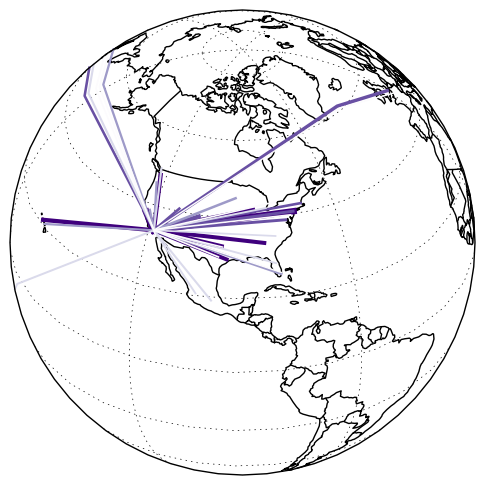

In [175]:
ax = gplt.sankey(airline_city_pairs.query('Origin == "Los Angeles, CA"'), start='Starting Point', end='Ending Point',
                 projection=ccrs.Orthographic(), scale='PASSENGERS', hue='PASSENGERS', cmap='Purples')
ax.set_global()
ax.outline_patch.set_visible(True)
ax.gridlines()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)

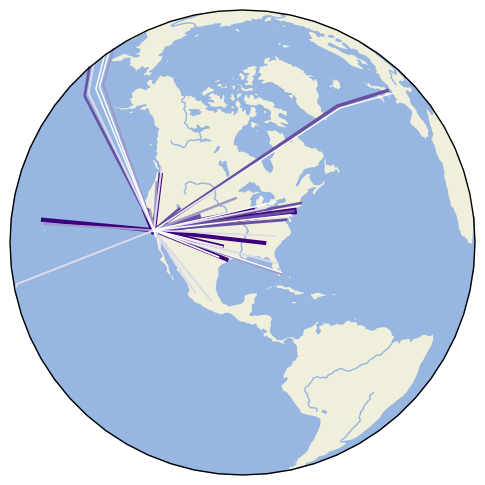

In [176]:
import cartopy

ax = gplt.sankey(airline_city_pairs.query('Origin == "Los Angeles, CA"'), start='Starting Point', end='Ending Point',
                 projection=ccrs.Orthographic(), scale='PASSENGERS', hue='PASSENGERS', cmap='Purples')
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES)
ax.add_feature(cartopy.feature.RIVERS)

In [178]:
import matplotlib.pyplot as plt

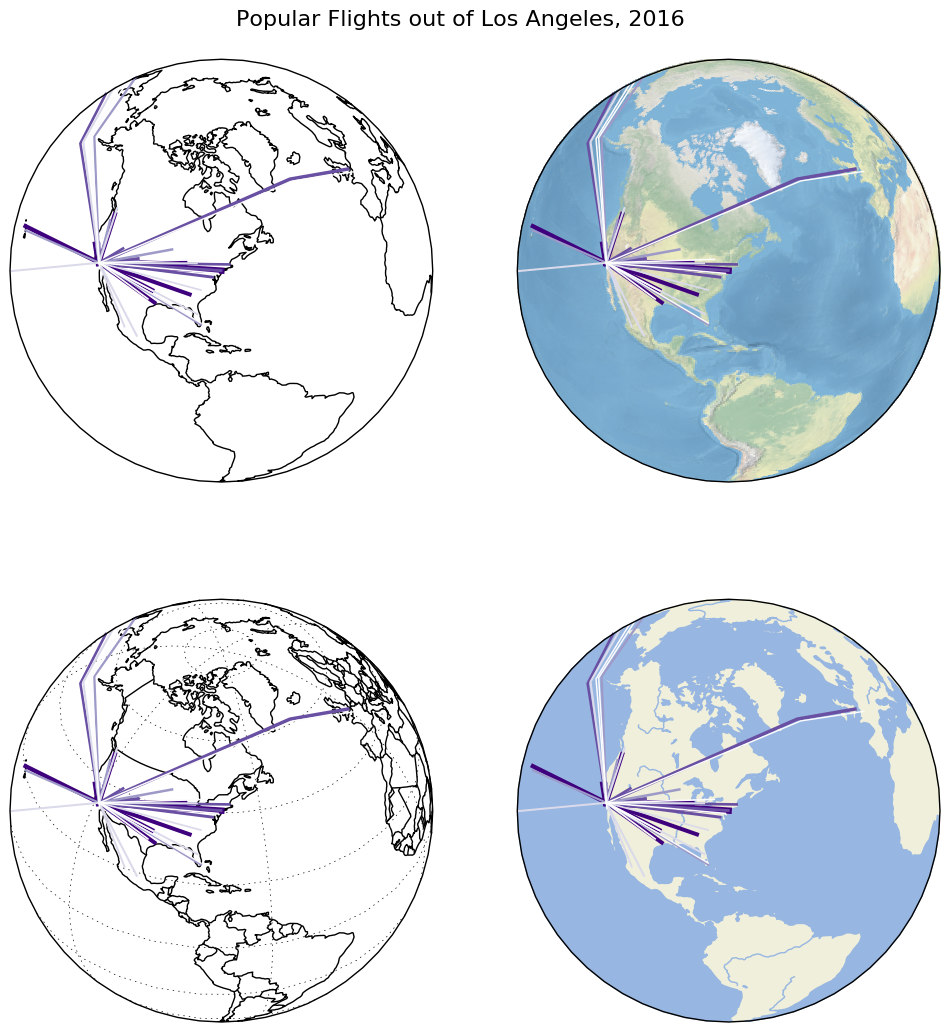

In [182]:
f, axarr = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={
        'projection': ccrs.Orthographic(central_latitude=40.7128, central_longitude=-74.0059)
        #ccrs.Orthographic(central_latitude=40.7128, central_longitude=-74.0059)
    })
plt.suptitle('Popular Flights out of Los Angeles, 2016', fontsize=16)
plt.subplots_adjust(top=0.95)


ax = gplt.sankey(airline_city_pairs.query('Origin == "Los Angeles, CA"'), start='Starting Point', end='Ending Point',
                 projection=ccrs.Orthographic(), scale='PASSENGERS', hue='PASSENGERS', cmap='Purples', ax=axarr[0][0])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()

ax = gplt.sankey(airline_city_pairs.query('Origin == "Los Angeles, CA"'), start='Starting Point', end='Ending Point',
                 projection=ccrs.Orthographic(), scale='PASSENGERS', hue='PASSENGERS', cmap='Purples', ax=axarr[0][1])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.stock_img()

ax = gplt.sankey(airline_city_pairs.query('Origin == "Los Angeles, CA"'), start='Starting Point', end='Ending Point',
                 projection=ccrs.Orthographic(), scale='PASSENGERS', hue='PASSENGERS', cmap='Purples', ax=axarr[1][0])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.gridlines()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)

ax = gplt.sankey(airline_city_pairs.query('Origin == "Los Angeles, CA"'), start='Starting Point', end='Ending Point',
                 projection=ccrs.Orthographic(), scale='PASSENGERS', hue='PASSENGERS', cmap='Purples', ax=axarr[1][1])
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES)
ax.add_feature(cartopy.feature.RIVERS)

In [198]:
airline_city_pairs.to_csv('../data/world_flights/flights.csv')